# Project 3: Web APIs & NLP

#### By Saiful Hasan

## Problem Statement

I am a co-founder of a small tech company which wants to develop an online streaming platform naming 'NeXfy' with a desire to compete with Netflix and Spotify. We want to serve the consumer with both movies and music on a same online platform. We also want to place a blog section where user can leave their reviews, stories and start any discussion. As a part of it we want to establish a model which can segregate the posts based on their title text so when someone searches for ‘movies’ or ‘music’, the relevant posts show up for them. Also, the model will help us to understand the users’ usage pattern, demand in future for further business expansion. As a part of this project we want to try different classification models and select the best model that satisfy our target. We have chosen to use classification metric, accuracy score to select the best performing model.

## Table of contents

- [Import Library](#Import-Library)
- [Import Data](#Import-Data)
- [Data Cleaning](#Data-Cleaning)
- [Pre-processing corpus](#Pre-processing-corpus)
- [Model Preparation](#Model-Preparation)
- [Modelling](#Modelling)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion](#Conclusion)
- [Recommendation](#Recommendation)

## Executive Summary

As a part of a tech company I have the task to establish a model for our new initiative of creating a online platform where we also want to introduce blog post options. So, our established model would need to be able to segregate the posts based on their title text. Due to the problem nature we have tried several classification models to come up with a model with best accuracy score. It means that we want a model that can predict most observations correctly. For analysis, we used around 4800 submissions. Before modelling we did some cleaning and model preparation. We set subreddit type as target variable. So basically, our model will predict if an observation/subreddit is a movie subreddit or a music subreddit based on the title text. The analysis suggests that LF-IDF + logistic regression is the best model with highest accuracy score of 88.39%. So, we recommend to start our initiative with the model we developed. However, still there is room for improvement with our model and perhaps, we may consider for second layer filtration.

##  Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import nltk
from nltk.stem import WordNetLemmatizer #Import lemmatizer
from nltk.tokenize import RegexpTokenizer # Import Tokenizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import TransformerMixin
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
RANDOM_STATE = 42

##  Import Data

In [2]:
df_movie = pd.read_csv("../Data/data_movies.csv")

In [3]:
df_music = pd.read_csv("../Data/data_music.csv")

In [4]:
print(df_movie.shape)
print(df_music.shape)

(2723, 9)
(2014, 9)


So, we have 2723 submission for 'movies' subreddit and 2014 for 'music' subreddit for our classification analysis

In [5]:
df = df_movie.append(df_music)  # creating a new dataframe that includes all data

In [6]:
df.shape

(4737, 9)

In [7]:
df[:2]

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Need help to find a name of cyberpunk movie I ...,[removed],movies,1584584017,slvrbat,0,1,True,2020-03-18
1,my coronavirus movie picks,pls comment if you want too add films or categ...,movies,1584584059,Bobatron1010,13,2,True,2020-03-18


##  Data Cleaning 

In [8]:
df.duplicated().sum()  #checking duplicate

0

In [9]:
df[:2]

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Need help to find a name of cyberpunk movie I ...,[removed],movies,1584584017,slvrbat,0,1,True,2020-03-18
1,my coronavirus movie picks,pls comment if you want too add films or categ...,movies,1584584059,Bobatron1010,13,2,True,2020-03-18


In [10]:
#assigning values to target variable 

df['subreddit'] = [1 if i == 'movies' else 0 for i in df['subreddit']]  

In [11]:
#writing function to clean title
#adopted and modified from https://towardsdatascience.com/the-real-world-as-seen-on-twitter-sentiment-analysis-part-one-5ac2d06b63fb
#adopted and modified from https://towardsdatascience.com/getting-your-text-data-ready-for-your-natural-language-processing-journey-744d52912867
#adopted and modified Matt Brems code  

def review_to_title(title):
    
    # Remove non-letters.
    title = re.sub("[^a-zA-Z]", " ", title)
    
    # Convert to lower case
    title = title.lower()
    
    # Remove hashtags
    title = re.sub(r'#\w*', '', title)
    
    # Remove HTML special entities (e.g. &amp;)
    title = re.sub(r'\&\w*;', '', title)
    
    #punctuation
    title = re.sub(r'[?|!|\'|#]', r'', title)
    
    # Remove hyperlinks
    title = re.sub(r'https?:\/\/.*\/\w*', '', title)
    
    # Remove whitespace (including new line characters)
    title = re.sub(r'\s\s+', ' ', title)
    
    return title 

In [12]:
df['title'] = df['title'].map(review_to_title)  #including the cleaned title in dataframe

In [13]:
df.shape

(4737, 9)

In [14]:
df['title'].isnull().sum()  #checking null values

0

In [15]:
# Lemmatizing
# idea : https://www.guru99.com/stemming-lemmatization-python-nltk.html

lemmatizer = WordNetLemmatizer()

def lemmatize_words(title):
    words = title.split()
    lemma_words = ''
    for word in words:
        lemma_words += (lemmatizer.lemmatize(word) + ' ')
    return lemma_words

In [16]:
df['title'] = df['title'].apply(lemmatize_words)

##  Pre-processing corpus

### Brief exploration on corpus 

In [17]:
#countvectorizer on whole data 

count_vect = CountVectorizer(
                             analyzer = "word", 
                             stop_words = "english", 
                             max_features = 20,
                             ngram_range= (1,2)
                            )

df_words = count_vect.fit_transform(df['title'])  #fit_transform the vectorizer
df_words = df_words.toarray() #output

In [18]:
print(list(count_vect.get_feature_names())[:15])

['album', 'amp', 'best', 'film', 'good', 'help', 'just', 'know', 'like', 'looking', 'movie', 'music', 'need', 'new', 'song']


In [19]:
covec_df = pd.DataFrame(df_words, columns = count_vect.get_feature_names()) # creating a dataframe

Text(0, 0.5, 'words')

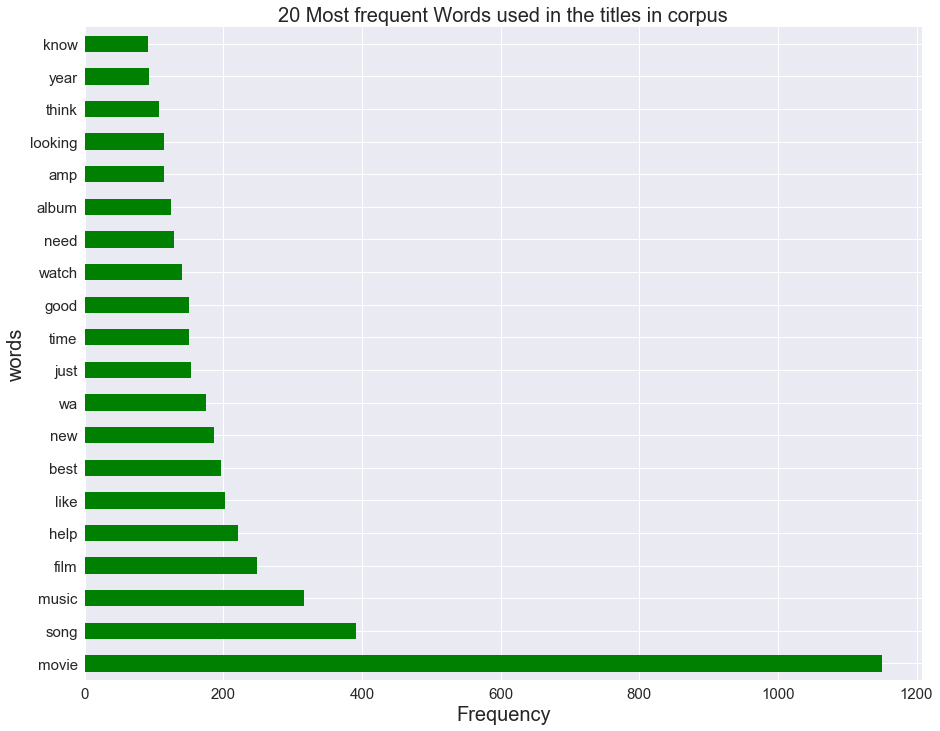

In [20]:
#plotting the most frequent words in the title in corpus

plt.style.use('seaborn')
plt.figure(figsize = (15,12))
covec_df.sum().sort_values(ascending=False).plot(kind = 'barh', color ='g', fontsize = 15)
plt.title("20 Most frequent Words used in the titles in corpus", fontsize = 20)
plt.xlabel('Frequency', fontsize =20)
plt.ylabel ('words', fontsize = 20)

We see that the frequency of word 'movie' is way higher than other words in the whole dataset. 'song' and 'music' are the second and third most frequent words in the dataset. We see that some short forms of words or phrases have been used in the subreddits, e.g. 'amp' for ampifier and 'wa' for what. 

In [21]:
print(len(df['title']))

4737


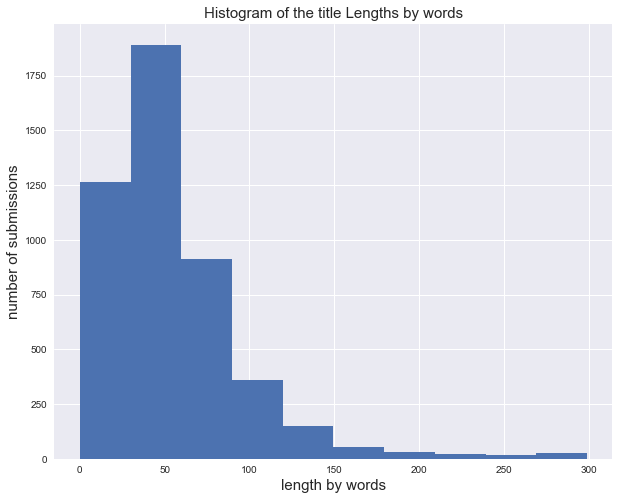

In [22]:
#plotting the length of titles in histogram 

plt.style.use('seaborn')
plt.figure(figsize = (10,8))
lengths_of_posts = [len(each) for each in df['title']]  #adopted code from Noah
plt.hist(lengths_of_posts)
plt.xlabel('length by words', fontsize =15)
plt.ylabel ('number of submissions', fontsize = 15)
plt.title('Histogram of the title Lengths by words', fontsize = 15);

The length of the title is actaully the number of words per title.The Histogram suggets that most of the titles' length are below 150 words, while some titles are lengthy enough to have 200- 300 words.

Text(0, 0.5, 'subreddit:    1 = Movie  0 = Music')

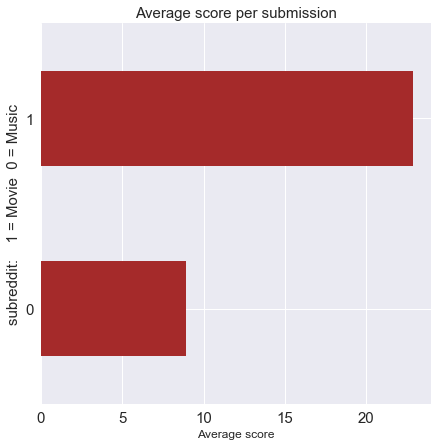

In [23]:
#plotting the average score for 'movie' subreddit and 'music' subreddit

plt.style.use('seaborn')
plt.figure(figsize = (7,7))
df.groupby('subreddit')['score'].mean().plot(kind='barh', color ='brown', fontsize = 15);
plt.title('Average score per submission', fontsize = 15)
plt.xlabel('Average score', fontsize =12)
plt.ylabel ('subreddit:    1 = Movie  0 = Music', fontsize = 15)

A submission's score is simply the number of upvotes minus the number of downvotes. So, the 'movies' subreddits's average score is higher than the 'music' subreddit, which might be the result of active participations from 'movies' subreddit users. 

reference: https://www.reddit.com/wiki/faq#wiki_how_is_a_submission.27s_score_determined.3F

### Brief exploration on movies and music dataset individually

### _Counvectorizer_

In [24]:
from nltk.corpus import stopwords
english_stopwords = stopwords.words("english")
new_stopwords = english_stopwords + ['help', 'wa', 'need', 'like', 'movie', 'youtube']

In [25]:
#most frequent words for movies

count_vect = CountVectorizer(
                             analyzer = "word", 
                             stop_words = new_stopwords, 
                             max_features = 20,
                             ngram_range= (1,2)
                            )

vector_input_music = df[df['subreddit'] == 1]['title']  # input for CountVectorizer
movie_words = count_vect.fit_transform(vector_input_music)  #fit_transform the vectorizer
movie_words = movie_words.toarray() #output

In [26]:
print(list(count_vect.get_feature_names()))

['actor', 'anyone', 'best', 'doe', 'endgame', 'film', 'find', 'get', 'good', 'name', 'new', 'one', 'scene', 'spoiler', 'think', 'time', 'watch', 'watched', 'would', 'year']


In [27]:
covec_movie = pd.DataFrame(movie_words, columns = count_vect.get_feature_names())  #creating Dataframe

Text(0, 0.5, 'words')

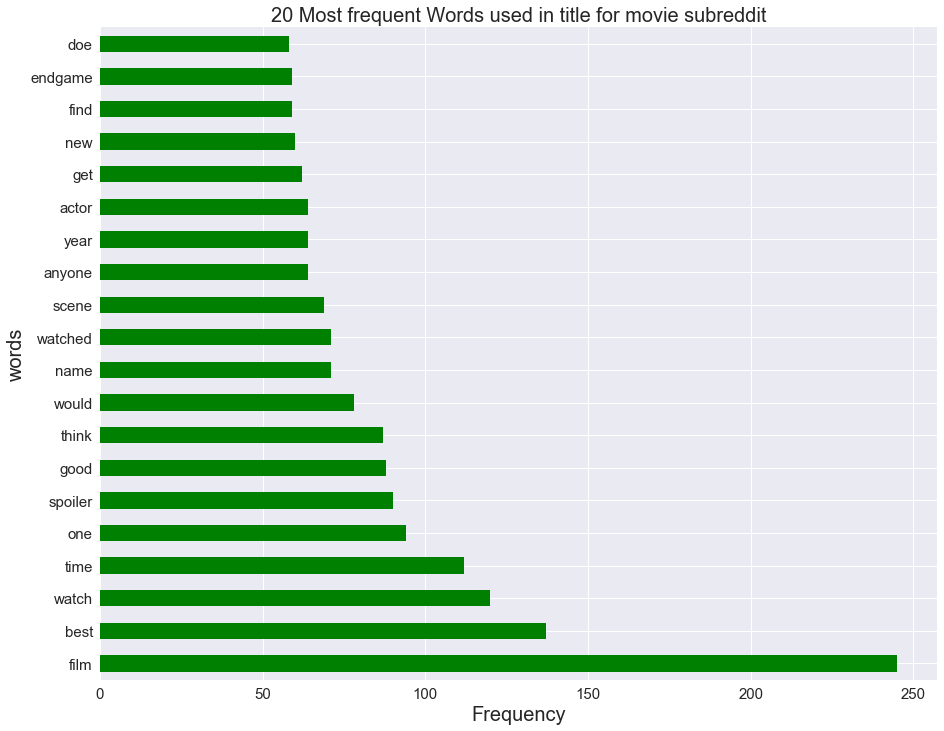

In [28]:
#plotting 20 most frequent words for movie subreddit

plt.style.use('seaborn')
plt.figure(figsize = (15,12))
covec_movie.sum().sort_values(ascending= False).plot(kind = 'barh', color ='g', fontsize = 15)
plt.title("20 Most frequent Words used in title for movie subreddit", fontsize = 20)
plt.xlabel('Frequency', fontsize =20)
plt.ylabel ('words', fontsize = 20)

Not to surprise that words like 'movie', 'film, is the top two most frequent words. there's is also movie names like 'endgame' and short form of words like 'doe' which stands for depend on experience. 

In [29]:
count_vect = CountVectorizer(
                             analyzer = "word", 
                             stop_words = new_stopwords, 
                             max_features = 20,
                             ngram_range= (2,2)
                            )

vector_input_music = df[df['subreddit'] == 1]['title']  # input for CountVectorizer
movie_words = count_vect.fit_transform(vector_input_music)  #fit_transform the vectorizer
movie_words = movie_words.toarray() #output

In [30]:
covec_movie = pd.DataFrame(movie_words, columns = count_vect.get_feature_names())  #creating Dataframe

Text(0, 0.5, 'phrases')

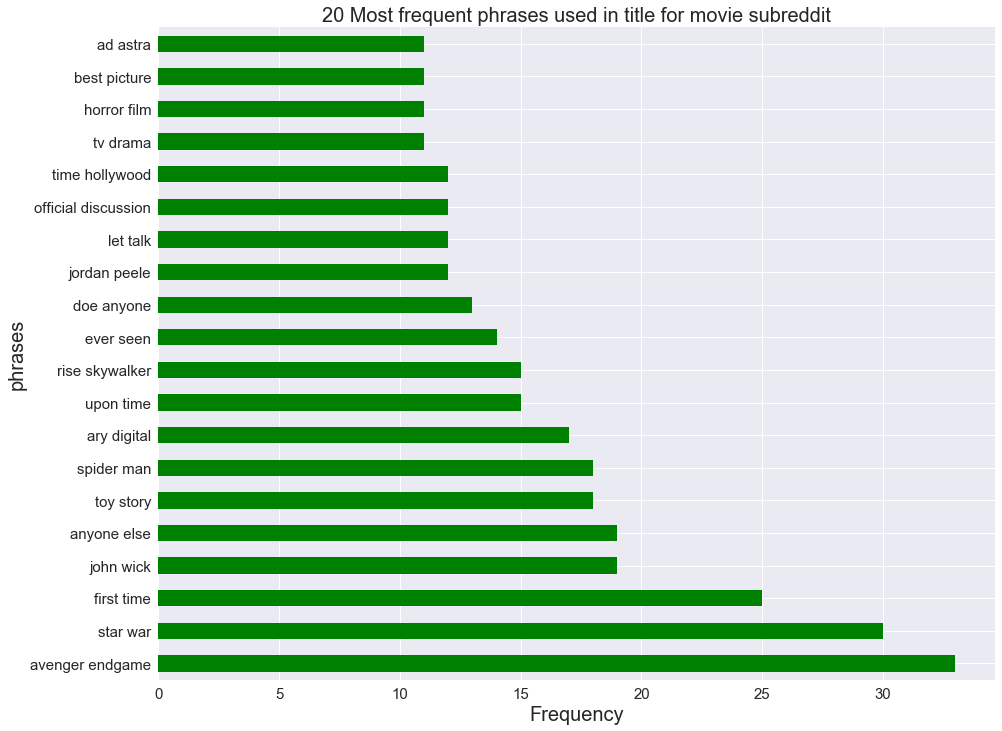

In [31]:
#plotting 20 most frequent words for movie subreddit

plt.style.use('seaborn')
plt.figure(figsize = (15,12))
covec_movie.sum().sort_values(ascending= False).plot(kind = 'barh', color ='g', fontsize = 15)
plt.title("20 Most frequent phrases used in title for movie subreddit", fontsize = 20)
plt.xlabel('Frequency', fontsize =20)
plt.ylabel ('phrases', fontsize = 20)

In [32]:
#most frequent words for music

count_vect = CountVectorizer(
                            analyzer = "word", 
                             stop_words = "english", 
                             max_features = 20,
                             ngram_range=(1, 2)
                            ) 

vector_input_music = df[df['subreddit'] == 0]['title'] # input for CountVectorizer

music_words = count_vect.fit_transform(vector_input_music) #fit_transform the vectorizer

music_words = music_words.toarray() #output 

In [33]:
print(list(count_vect.get_feature_names()))

['album', 'amp', 'artist', 'band', 'best', 'cover', 'good', 'help', 'http', 'like', 'looking', 'music', 'need', 'new', 'playlist', 'rock', 'song', 'steelasophical', 'steelband', 'video']


In [34]:
covec_music = pd.DataFrame(music_words, columns = count_vect.get_feature_names()) #creating Dataframe

Text(0, 0.5, 'words')

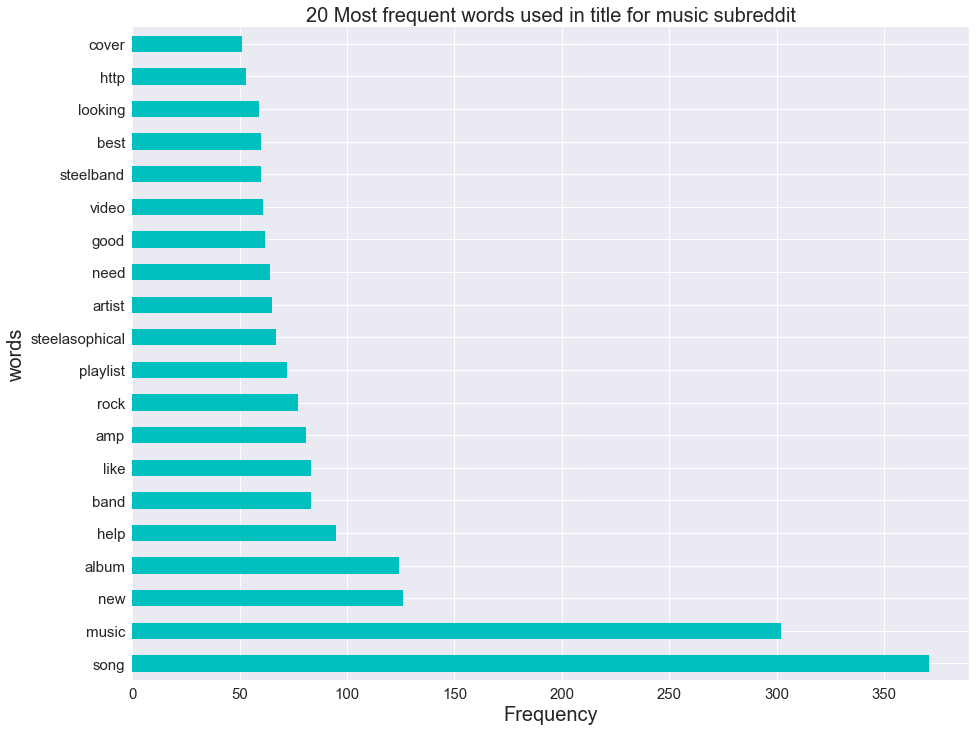

In [35]:
#plotting 20 most frequent words for music subreddit

plt.style.use('seaborn')
plt.figure(figsize = (15,12))
covec_music.sum().sort_values(ascending=False).plot(kind = 'barh', color ='c', fontsize = 15)
plt.title("20 Most frequent words used in title for music subreddit", fontsize = 20)
plt.xlabel('Frequency', fontsize =20)
plt.ylabel ('words', fontsize = 20)

Likewise 'movies' subreddit, not to surprise that we got the words like 'song', 'music', 'album' are the most frequent words. However, we can see that few words are common between the two subreddits, e.g. 'like', 'help', 'best'

### _TF-IDF Vectorizer_

TF-IDF is the short form for “Term Frequency — Inverse Document Frequency”. This is another technique to quantify a word in document. TF-IDF generally compute a weight to each word which signifies the importance of the word in the document and corpus. 

In [36]:
#tfidf vectorizer for movie words

tfdf = TfidfVectorizer(
                     analyzer = "word", 
                     stop_words = 'english', 
                     max_features = 10000, 
                     ngram_range = (1, 2)
                         )

tfdf_input_movie = df[df['subreddit'] == 1]['title']  # input for CountVectorizer

tfdf_movie_words = tfdf.fit_transform(tfdf_input_movie) #fit-transform

tfdf_movie_words = tfdf_movie_words.toarray() #output

tfdf_movie = pd.DataFrame(tfdf_movie_words, columns=tfdf.get_feature_names())  #create Dataframe

tfdf_movie.sum().sort_values(ascending=False).head(10)  

movie      170.736088
film        43.897307
help        40.614416
best        32.627449
watch       27.695621
wa          24.072006
like        23.337639
time        22.249508
good        21.254840
spoiler     20.900867
dtype: float64

In [37]:
#tfidf vectorizer for music words

tfdf = TfidfVectorizer(
                     analyzer = "word", 
                     stop_words = 'english', 
                     max_features = 10000, 
                     ngram_range = (1, 2)
                         )

tfdf_input_music = df[df['subreddit'] == 0]['title']  # input for CountVectorizer

tfdf_music_words = tfdf.fit_transform(tfdf_input_music) #fit-transform

tfdf_music_words = tfdf_music_words.toarray() #output

tfdf_music = pd.DataFrame(tfdf_music_words, columns=tfdf.get_feature_names())  #create Dataframe

tfdf_music.sum().sort_values(ascending=False).head(10)  

song        68.327028
music       49.640428
help        33.010439
album       24.046394
new         23.307100
band        17.784376
looking     17.755175
need        17.753946
playlist    16.433595
genre       16.352990
dtype: float64

##  Model Preparation

In [38]:
#setting X and y(target variable)

X = df['title']
y = df['subreddit']

#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.40, random_state=RANDOM_STATE)

In [39]:
# writing function for classification metrics

def classification_metric(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel();
    acc = ((tp + tn)/(tp + tn + fp + fn))
    sen = (tp /(tp+fn))
    spec = (tn/(tn+fp))
    pre = (tp/(tp+fp))
    clas = 1 -acc
    print('Classification metric:')
    print("accuracy:               {:.4f} ".format(((tp + tn)/(tp + tn + fp + fn))))
    #print("missclassification:     {:.4f} ".format(1 - ((tp + tn)/(tp + tn + fp + fn))))
   # print("sensitivity:            {:.4f}".format((tp /(tp+fn))))
   # print("specificity:            {:.4f} ".format((tn/(tn+fp))))
    #print("precise:                {:.4f} ".format((tp/(tp+fp))))

##  Modelling 

### Baseline Model

For classification, there is no mean to predict, so a baseline classification model simply predicts the most frequently occurring class.

In [40]:
print('Best baseline accuracy on TRAIN set:', y_train.value_counts(normalize=True).max())
print('Best baseline accuracy on TEST set:', y_test.value_counts(normalize=True).max())

Best baseline accuracy on TRAIN set: 0.5749472202674173
Best baseline accuracy on TEST set: 0.5746701846965699


The accuracy score for both train set and test set is close enough. However, the accuracy of around 57% is the not satisfactory. We will try few models below to see if we can improve the accuracy

### CVEC + Logistic Regression

In [41]:
# Instantiate pipeline.
pipe_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('logit', LogisticRegression(solver = 'lbfgs'))
])

#Params-dictionary
params_grid = {
    'cv__max_features': [1000, 1500],
    'cv__stop_words': ['english'],
    'cv__ngram_range': [(1,1), (1,2)],
    'logit__class_weight': ['balanced', 'distance'],
    'logit__penalty': ['l2'],
    'logit__C': [.001, 0.01, 0.1, 1]
}

# GridSearch over pipeline with given grid of parameters.
logit_cv = GridSearchCV(pipe_cv, 
                     params_grid, 
                     cv=5, 
                     scoring ='accuracy')

# Fit model.
logit_cv.fit(X_train, y_train);

In [42]:
logit_cv.best_params_

{'cv__max_features': 1500,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': 'english',
 'logit__C': 1,
 'logit__class_weight': 'balanced',
 'logit__penalty': 'l2'}

In [43]:
logit_cv.best_estimator_ ;

In [44]:
#train_score = logit_cv.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(logit_cv.score(X_train, y_train)))
#test_score = logit_cv.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(logit_cv.score(X_test, y_test)))

Best TRAIN set accuracy: 0.9469
Best TEST set accuracy: 0.8749


In [45]:
# return classification metric
classification_metric(y_test, logit_cv.predict(X_test))

Classification metric:
accuracy:               0.8749 


We see a improvement in the accuracy score. There is somewhat difference between accuracy on test set and train set.

### TF-IDF + Logistic Regression

In [46]:
# Instantiate pipeline.
pipe_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('logit', LogisticRegression())
])

#Params-dictionary
params_grid = {
    'tf__max_features': [1000, 1500],
    'tf__stop_words': ['english'],
    'tf__ngram_range': [(1,1), (1,2)],
     'logit__penalty': ['l2'],
    'logit__C': [.001, 0.01, 0.1, 1],
     'logit__class_weight': ['balanced', 'distance'],
    'logit__verbose': [0]
}

# GridSearch over pipeline with given grid of parameters.
logit_tf = GridSearchCV(pipe_tf, params_grid, cv=5)

# Fit model.
logit_tf.fit(X_train, y_train);

In [47]:
logit_tf.best_params_

{'logit__C': 1,
 'logit__class_weight': 'balanced',
 'logit__penalty': 'l2',
 'logit__verbose': 0,
 'tf__max_features': 1500,
 'tf__ngram_range': (1, 1),
 'tf__stop_words': 'english'}

In [97]:
logit_tf.best_estimator_ ;

In [98]:
Coefficient_list = pd.DataFrame(data=logit.coef_.T, index=tfdf.get_feature_names());  #create daatframe
Coefficient_list.columns = ['coefficient']

In [103]:
Coefficient_list['coefficient'].sort_values(ascending = False)[10:] 

remember name               0.929944
best far                    0.904049
let talk                    0.850788
infinity war                0.841690
trying find                 0.837463
                              ...   
finding song               -1.415853
steelasophical steelband   -1.593135
looking song               -1.652794
find song                  -1.881963
hip hop                    -2.193025
Name: coefficient, Length: 9990, dtype: float64

In [49]:
#train_score = logit_tf.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(logit_tf.score(X_train, y_train)))
#test_score = logit_tf.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(logit_tf.score(X_test, y_test)))

Best TRAIN set accuracy: 0.9469
Best TEST set accuracy: 0.8839


In [50]:
# return classification metric
classification_metric(y_test, logit_tf.predict(X_test))

Classification metric:
accuracy:               0.8839 


The accuracy score has been improved by TD-IDF with  Logistic model. The difference between accuracy on train and test set has shrinked a bit as well. 

### CVEC + KNN

In [51]:
pipe_cv = Pipeline(steps=[
    ('cv', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

#Params-dictionary
pipe_params = { 'cv__max_features': [1000, 1500],
                 'cv__stop_words': ['english'],
                 'cv__ngram_range': [(1,1), (1,2)],
                 'knn__metric': ['minkowski','euclidean', 'manhattan'],
                'knn__n_neighbors': [3, 5],
                 'knn__weights': ['uniform', 'distance']}

knn_cv = GridSearchCV(pipe_cv, 
                    pipe_params, 
                    cv = 5)
# Fit model.
knn_cv.fit(X_train, y_train);

In [52]:
knn_cv.best_estimator_ ;

In [53]:
knn_cv.best_score_

0.8170220797544493

In [54]:
#train_score = knn_cv.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(knn_cv.score(X_train, y_train)))
#test_score = knn_cv.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(knn_cv.score(X_test, y_test)))

Best TRAIN set accuracy: 0.9609
Best TEST set accuracy: 0.8069


In [55]:
# return classification metric
classification_metric(y_test, knn_cv.predict(X_test))

Classification metric:
accuracy:               0.8069 


The accuracy score has drop for CVEC + KNN model than the logistic models (both with CEVC with and TF-IDF with). The differences between score for train and test has widened as well.

## TF-IDF + KNN

In [56]:
pipe_tf = Pipeline(steps=[
    ('tfdf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

#Params-dictionary
pipe_params = { 'tfdf__max_features': [1000, 1500],
                 'tfdf__stop_words': [{'english'}],
                 'tfdf__ngram_range': [(1,1), (1,2)],
                 'knn__metric': ['minkowski','euclidean', 'manhattan'],
                 'knn__n_neighbors': [3, 5],
                  'knn__weights': ['uniform', 'distance']}

knn_tf = GridSearchCV(pipe_tf, 
                    pipe_params, 
                    cv = 5) 
# Fit model                        
knn_tf.fit(X_train, y_train);

In [57]:
knn_tf.best_estimator_ ;

In [58]:
knn_tf.best_score_

0.7156909824500607

In [59]:
#train_score = knn_tf.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(knn_tf.score(X_train, y_train)))
#test_score = knn_tf.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(knn_tf.score(X_test, y_test)))

Best TRAIN set accuracy: 0.9778
Best TEST set accuracy: 0.7261


In [60]:
# return classification metric
classification_metric(y_test, knn_tf.predict(X_test))

Classification metric:
accuracy:               0.7261 


The accuracy score has drop further for TF-IDF + KNN model. The differences between score for train and test has widened as well suggesting overfit model. The accuracy score is not that up to satisfcatory level.

### CVEC + Naive bayes (Multinomial)

In [61]:
pipe_cv = Pipeline(steps=[
    ('cv', CountVectorizer()),
    ('multNB', MultinomialNB())
])

#Params-dictionary
pipe_params = { 'cv__max_features': [1000, 1500],
                 'cv__stop_words': [{'english'}],
                 'cv__ngram_range': [(1,1), (1,2)],
                  'multNB__alpha':  [2],
                   'multNB__fit_prior': [True],
                  'multNB__class_prior': [None]}

gs_multNB = GridSearchCV(pipe_cv, 
                    pipe_params, 
                    cv = 5) 
# Fit model                              
gs_multNB.fit(X_train, y_train);

In [62]:
gs_multNB.best_estimator_ ;

In [63]:
gs_multNB.get_params ;

In [64]:
gs_multNB.best_score_

0.8712202034703829

In [65]:
#train_score = gs_multNB.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(gs_multNB.score(X_train, y_train)))
#test_score = gs_multNB.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(gs_multNB.score(X_test, y_test)))

Best TRAIN set accuracy: 0.9152
Best TEST set accuracy: 0.8802


In [66]:
# return classification metric
classification_metric(y_test, gs_multNB.predict(X_test))

Classification metric:
accuracy:               0.8802 


The accuracy has jumped to 88% which is close to our TF-IDF + Logistic model. 

### TD-IDF + Naive bayes (Gaussian )

In [67]:
# adapted from https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [68]:

pipe_tf = Pipeline(steps=[
    ('tfdf', TfidfVectorizer()),
    ("_",DenseTransformer()),
    ('gasNB', GaussianNB())
])

#Params-dictionary
pipe_params = { 'tfdf__max_features': [1000, 1500],
                 'tfdf__stop_words': [{'english'}],
                 'tfdf__ngram_range': [(1,1), (1,2)],
                  'gasNB__var_smoothing': [1e-8]}
            
gs_gasNB = GridSearchCV(pipe_tf, 
                    pipe_params, 
                    cv = 5) 


# Fit model
gs_gasNB.fit(X_train, y_train);

In [69]:
gs_gasNB.best_estimator_ ;

In [70]:
gs_gasNB.best_score_

0.7712827050174509

In [71]:
#train_score = gs_gasNB.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(gs_gasNB.score(X_train, y_train)))
#test_score = gs_gasNB.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(gs_gasNB.score(X_test, y_test)))

Best TRAIN set accuracy: 0.8642
Best TEST set accuracy: 0.7683


In [72]:
# return classification metric
classification_metric(y_test, gs_gasNB.predict(X_test))

Classification metric:
accuracy:               0.7683 


We can se that Naive Bayes (Multinomial) performs better than Naive Bayes (Gaussian) in terms of accuracy. So far TF-IDF is has most accuracy score. We will try few other classification models to see if we can improve the accuracy score even further.

### CVEC + Decision Tree

In [73]:
# Simple pipeline - list of tuples
cvec_tree_pipe = Pipeline(steps=[
    ('cv', CountVectorizer()),
    ('tree', DecisionTreeClassifier())
])

#Params-dictionary
cvec_tree_params = {'cv__max_features': [1000, 1500],
                 'cv__stop_words': [{'english'}],
                 'cv__ngram_range': [(1,1), (1,2)],
                    'cv__min_df': [5],
                    'cv__max_df': [.5,.1,.2],
                 'tree__max_depth': [10,15,20],
                 'tree__min_samples_leaf': [2],
                  'tree__min_samples_split': [3]}

gs_tree = GridSearchCV(cvec_tree_pipe, 
                    cvec_tree_params, 
                    cv = 5) 
# Fit model                         
gs_tree.fit(X_train, y_train);

In [74]:
gs_tree.best_estimator_ ;

In [75]:
gs_tree.best_score_

0.7853634990965123

In [76]:
#train_score = gs_tree.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(gs_tree.score(X_train, y_train)))
#test_score = gs_tree.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(gs_tree.score(X_test, y_test)))

Best TRAIN set accuracy: 0.8061
Best TEST set accuracy: 0.7757


In [77]:
# return classification metric
classification_metric(y_test, gs_tree.predict(X_test))

Classification metric:
accuracy:               0.7757 


The scores suggest that above CART model is an slightly overfit model (accuracy on train set is slightly higher than the accuracy on test set). The difference is not that much. Moreover, the accuracy on test set is lower than the 80%. We already have model with aroun 88% accuracy. So, we will try further to see if any kind of improvment can be achieved. Therefore, we should try bagging classification model.

### CVCE + Bagging Classifier

In [78]:
# Simple pipeline - list of tuples
cvec_bagg_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('bagg', BaggingClassifier(base_estimator=DecisionTreeClassifier()))
])

#Params-dictionary
cvec_bagg_params = { 'cvec__max_features': [1000, 1500],
                 'cvec__stop_words': [{'english'}],
                    'cvec__min_df': [5],
                    'cvec__max_df': [.5],
                 'cvec__ngram_range': [(1,1), (1,2)],
                 'bagg__n_estimators': [2, 5, 10], 
                  'bagg__max_samples': [.001, .1, .5, 1]
                    }             

gs_bagg = GridSearchCV(cvec_bagg_pipe, 
                    cvec_bagg_params,
                      cv= 5) 

# Fit model                          
gs_bagg.fit(X_train, y_train);

In [79]:
 gs_bagg.best_estimator_ ;

In [80]:
gs_bagg.best_score_

0.8356784821406471

In [81]:
#train_score = gs_bagg.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(gs_bagg.score(X_train, y_train)))
#test_score = gs_bagg.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(gs_bagg.score(X_test, y_test)))

Best TRAIN set accuracy: 0.9381
Best TEST set accuracy: 0.8338


In [82]:
# return classification metric
classification_metric(y_test, gs_bagg.predict(X_test))

Classification metric:
accuracy:               0.8338 


The accuracy score has improved compared to CART model accuracy score. however, still below our best accuracy score 88%.

### CVCE + Randomforest

In [83]:
# Simple pipeline - list of tuples
cvec_rf_pipe = Pipeline(steps=[
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

#Params-dictionary
cvec_rf_params = { 'cvec__max_features': [1000, 1500],
                 'cvec__stop_words': [{'english'}],
                    'cvec__min_df': [5],
                    'cvec__max_df': [.5],
                 'cvec__ngram_range': [(1,1), (1,2)],
                 'rf__max_depth': [2, 5, 10], 
                 'rf__min_samples_leaf': [1],
                  'rf__min_samples_split': [3]
                    }             

gs_rf = GridSearchCV(cvec_rf_pipe, 
                    cvec_rf_params,
                      cv= 5) 

# Fit model                            
gs_rf.fit(X_train, y_train);

In [84]:
gs_rf.best_estimator_ ;
gs_rf.best_score_

0.8008446991262159

In [85]:
#train_score = gs_bagg.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(gs_rf.score(X_train, y_train)))
#test_score = gs_bagg.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(gs_rf.score(X_test, y_test)))

Best TRAIN set accuracy: 0.8107
Best TEST set accuracy: 0.7789


In [86]:
# return classification metric
classification_metric(y_test, gs_rf.predict(X_test))

Classification metric:
accuracy:               0.7789 


The accuracy has fallen further than Bagging Classifier model. So, couldn't improve the accuracy score than Bagging model.

## Model Selection

We have chosen __accuracy score__ as a matric to select our model. Accuracy score refers to the percentage of observations the model predicts correctly. 

In [87]:
print('Accuracy score for Baseline model on train set:{:.4f}'.format(y_train.value_counts(normalize=True).max()))
print('Accuracy score for Baseline model on test set: {:.4f}'.format(y_test.value_counts(normalize=True).max()))
print()
print('Accuracy score for CVCE + Logistic Regression on train set: {:.4f}'.format(logit_cv.score(X_train, y_train)))
print('Accuracy score for CVCE + Logistic Regression on test set: {:.4f}'.format(logit_cv.score(X_test, y_test)))
print()
print('Accuracy score for TF-IDF + Logistic Regression on train set: {:.4f}'.format(logit_tf.score(X_train, y_train)))
print('Accuracy score for TF-IDF + Logistic Regression on test set: {:.4f}'.format(logit_tf.score(X_test, y_test)))
print()
print('Accuracy score for CVEC + KNN on train set: {:.4f}'.format(knn_cv.score(X_train, y_train)))
print('Accuracy score for CVEC + KNN on test set: {:.4f}'.format(knn_cv.score(X_test, y_test)))
print()
print('Accuracy score for TF-IDF + KNN on train set: {:.4f}'.format(knn_tf.score(X_train, y_train)))
print('Accuracy score for TF-IDF + KNN on test set: {:.4f}'.format(knn_tf.score(X_test, y_test)))
print()
print('Accuracy score for CVEC + Multinomial on train set: {:.4f}'.format(gs_multNB.score(X_train, y_train)))
print('Accuracy score for CVEC + Multinomial on test set: {:.4f}'.format(gs_multNB.score(X_test, y_test)))
print()
print('Accuracy score for CVEC + Gaussaian on train set: {:.4f}'.format(gs_gasNB.score(X_train, y_train)))
print('Accuracy score for CVEC + Gaussaian on test set: {:.4f}'.format(gs_gasNB.score(X_test, y_test)))
print()
print('Accuracy score for CVEC + Decision Tree on train set: {:.4f}'.format(gs_tree.score(X_train, y_train)))
print('Accuracy score for CVEC + Decision Tree on test set: {:.4f}'.format(gs_tree.score(X_test, y_test)))
print()
print('Accuracy score for CVEC + Bagging Classification on train set: {:.4f}'.format(gs_bagg.score(X_train, y_train)))
print('Accuracy score for CVEC + Bagging Classification on test set: {:.4f}'.format(gs_bagg.score(X_test, y_test)))
print()
print('Accuracy score for CVEC + Random Forest on train set: {:.4f}'.format(gs_rf.score(X_train, y_train)))
print('Accuracy score for CVEC + Random forest on test set: {:.4f}'.format(gs_rf.score(X_test, y_test)))

Accuracy score for Baseline model on train set:0.5749
Accuracy score for Baseline model on test set: 0.5747

Accuracy score for CVCE + Logistic Regression on train set: 0.9469
Accuracy score for CVCE + Logistic Regression on test set: 0.8749

Accuracy score for TF-IDF + Logistic Regression on train set: 0.9469
Accuracy score for TF-IDF + Logistic Regression on test set: 0.8839

Accuracy score for CVEC + KNN on train set: 0.9609
Accuracy score for CVEC + KNN on test set: 0.8069

Accuracy score for TF-IDF + KNN on train set: 0.9778
Accuracy score for TF-IDF + KNN on test set: 0.7261

Accuracy score for CVEC + Multinomial on train set: 0.9152
Accuracy score for CVEC + Multinomial on test set: 0.8802

Accuracy score for CVEC + Gaussaian on train set: 0.8642
Accuracy score for CVEC + Gaussaian on test set: 0.7683

Accuracy score for CVEC + Decision Tree on train set: 0.8061
Accuracy score for CVEC + Decision Tree on test set: 0.7757

Accuracy score for CVEC + Bagging Classification on train

The findings suggest that only four model has above 80% accuracy score - CVEC+Logistic, IF-IDF + Logistic, CVEC + KNN, CVEC+Multinomial, CVEC + Bagging Classification model.

The accuracy scores on test sets for CVEC + Multinomial and TF-IDF with a logistic Regression model are very close. However, the difference (0.8839 - 0.8802) suggests that TF-IDF + Logistic regression has slightly better accuracy. 
Thus, we can conclude that TF-IDF + Logistic regression model has the highest accuracy score on test dataset. in effect, it suggests that __TF-IDF with a logistic Regression model__ performs better than any other model. With an __accuracy of 88.39%__, it also outperforms Baseline model. The accuracy score on train set is slightly higher than accuracy score on test set, however the difference is acceptable to qualify as a good model


Logistic regression is by far one of the most common classification algorithm. Logistic regression model is great at binary classifications and has interpretable coefficient. In our study the target variable is binary, if y = 1 it's movie subreddit and if y = 0 its music subreddit.

Below we will evaluate the TF-IDF with logistic Regression model using confusion matrix and coefficient interpretation. For coefficient interpretation we would use TF-IDF with logistic regression model but without Gridsearch.

## Model Evaluation

Our chosen metric accuracy takes into account all true predictions, both true positives and true negatives. The equation is as below:

$$
Accuracy = \frac{All Correct}{All Predictions}
$$

$$
= \frac{(TP + TN)} {(TP + FP + TN + FN)}
$$


The cosufion matric for our TF-IDF with a logistic Regression model is provided below:

In [88]:
#confusion matrix calculation

confusion_matrix(y_test, logit_tf.predict(X_test))
tn, fp, fn, tp = confusion_matrix(y_test,logit_tf.predict(X_test)).ravel()
print("True Negatives: ", tn)
print()
print("False Positives: ", fp)
print()
print("False Negatives: ", fn)
print()
print("True Positives: ", tp)

True Negatives:  718

False Positives:  88

False Negatives:  132

True Positives:  957


We can see that our selected model has more False Negatives than False Positives. 132 False negative score suggests that our model predicted 132 observations as music subreddits while they were actually movie subreddits. on the other hand, False Positive scores suggests that our model predicted 88 models as movie subreddits while they were actually music subreddits. the above equation suggests that to improve the model performance, our model would need to convert this false prediction to true predictions. In other word, to maximize the accuracy our model needs to minimize the false negatives and false positives. On the other side, True negatives and True Positives are the predictions model did accurately. for instance, 718 true negative means model has predicted 718 observation correctly as music subreddits, while 957 true positives mean model has predicted 957 observation correctly as movies subreddits. Minimizing the false predictions would eventually maximize the true predictions

As the model has accuracy score of 88.39%, it suggests that the misclassification rate is 11.61%. it is a measurement of what percentage of observations did the model incorrectly predict. If we review the most frequent words for both subreddits, we observe that there are few words that are common for both subreddits such as 'help' 'like' 'best'. So, it suggests that due to the presence of common words in two subreddits, our model misclassified few observations.  

In [89]:
#coefficient calculation

logit = LogisticRegression()
tfdf = TfidfVectorizer(
                     analyzer = "word", 
                     stop_words = new_stopwords, 
                     max_features = 10000, 
                     ngram_range = (2, 2)
                         )
pipe = Pipeline([
    ('tfdf', tfdf),
    ('model', logit)
])
pipe.fit(X_train, y_train)

print('Accuracy score for TF-IDF + Logistic Regression on train set: {:.4f}'.format(pipe.score(X_train, y_train)))
print('Accuracy score for TF-IDF + Logistic Regression on test set: {:.4f}'.format(pipe.score(X_test, y_test)))

logit.coef_;  #coeffcient 
Coefficient_list = pd.DataFrame(data=logit.coef_.T, index=tfdf.get_feature_names());  #create daatframe
Coefficient_list.columns = ['coefficient']
print()
print('Coeffcients')
print('.'*40)
Coefficient_list['coefficient'].sort_values(ascending = False)[:10]  #show top 10 features for interpretation

Accuracy score for TF-IDF + Logistic Regression on train set: 0.9697
Accuracy score for TF-IDF + Logistic Regression on test set: 0.6786

Coeffcients
........................................


star war               1.411844
john wick              1.370826
avenger endgame        1.285748
rise skywalker         1.142589
toy story              1.119625
spider man             1.112756
end game               1.049824
free full              1.026454
ad astra               1.025277
official discussion    0.930080
Name: coefficient, dtype: float64

In [90]:
np.exp(1.41)

4.095955404071176

In [91]:
Coefficient_list['coefficient'].sort_values(ascending = False)[-10:] 

bit ly                     -1.087302
http bit                   -1.087302
new music                  -1.116566
new single                 -1.164542
music video                -1.170269
finding song               -1.415853
steelasophical steelband   -1.593135
looking song               -1.652794
find song                  -1.881963
hip hop                    -2.193025
Name: coefficient, dtype: float64

Allthough this model is merely to interpret the coefficient, we wanted to see the model's accuracy score on train and test set to understand the model's fitness. The accuracy score is satisfactory though there is a difference between train set score and test set score. 

The coefficient refers to the relationship between predictors and target variables. Our target variable is the subreddit type - weather it is a movie subreddit or a music subreddit.


The coefficient for 'movie' words is 4.064 which refers that for a unit increase of the presence of word 'movie' in title, an observation is $e^{\beta_1} = e^{9.55} = 14045$ TIMES AS LIKELY to be a movie subreddit. So basically as the word 'movie' occurrence increases by one unit in the title, an observation is 14045 TIMES AS LIKELY to be a movie subreddit. On the other hand, The coefficient for 'song' words is -5.769 which refers that for a unit increase of the presence of word 'song' in title, an observation is $e^{\beta_1} = e^{-5.769} = 99.7$ percent LESS LIKELY to be a movie subreddit.


## Conclusion

Based on the analysis results we see that TF-IDF with a logistic Regression model performs better than other model. We have chosen accuracy score to select the best model. TF-IDF with a logistic Regression model has the highest accuracy score, which means that comparatively this model can predict highest percentage of observations correctly. The accuracy score for the selected model is above 88% on test dataset. Therefore, based on the analysis we did, we can expect that TF-IDF with a logistic Regression model can be useful technique to detect which blog post is about movies and which is about music just analysing the title of the post.  

## Recommendation

From the findings of the TF-IDF with a logistic Regression model I have come to these recommendations:

1. We can start our blog posting project on the basis of our analysis findings. Our model delivers expected results with 88% accuracy.
1. For maximizing accuracy score we need to minimize the false negative and false positive scores.
2. Since we didn't have 100% accuracy we may consider second layer of filtration.
